In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import Bounds, LinearConstraint, NonlinearConstraint, differential_evolution, minimize

from pnl.prototipo import (
    objective_prototipo,
    grad_objective_prototipo,
    make_constraints_prototipo,
    solve_global_then_local,
    solve_local,
    is_feasible,
)

from pnl.logistic_fit import logistic, make_synthetic_data, fit_local_lbfgsb, fit_global_de_then_local

## Parte A — Protótipo 2D (não convexo com restrições)

Problema:
- Objetivo: $f(x_1,x_2) = (x_1-1)^2 + (x_2-2)^2 + 0.5\sin(3x_1)\sin(3x_2)$ (não convexo pelo termo senoidal)
- Restrições: $x_1^2 + x_2^2 ≤ 5$ e $x_1 + x_2 ≥ 1$ (conjunto viável convexo)

In [4]:
cons = make_constraints_prototipo()
bounds = Bounds([-3.0, -3.0], [3.0, 3.0])

x0s = [np.array([-2.5, 2.5]), np.array([2.5, -1.0]), np.array([0.2, 0.9])]
methods = ["SLSQP", "trust-constr"]

local_results = []
for x0 in x0s:
    for m in methods:
        r = solve_local(x0, m, bounds, cons['nonlinear'], cons['linear'])
        local_results.append(r)
        print(f"{m:12s} x0={x0} -> x={r.x}, f={r.fun:.6f}, feas={is_feasible(r.x)}, ok={r.success}")

g, ref = solve_global_then_local(seed=0)
print('=== Global → Local ===')
print(f"Global  : x={g.x}, f={g.fun:.6f}, feas={is_feasible(g.x)}")
print(f"Refino  : x={ref.x}, f={ref.fun:.6f}, feas={is_feasible(ref.x)}, ok={ref.success}")

SLSQP        x0=[-2.5  2.5] -> x=[0.68465965 1.71731089], f=-0.221322, feas=True, ok=True
trust-constr x0=[-2.5  2.5] -> x=[0.68466795 1.71733831], f=-0.221322, feas=True, ok=True
SLSQP        x0=[ 2.5 -1. ] -> x=[0.68465496 1.71738901], f=-0.221322, feas=True, ok=True
trust-constr x0=[ 2.5 -1. ] -> x=[0.68466855 1.71734025], f=-0.221322, feas=True, ok=True
SLSQP        x0=[0.2 0.9] -> x=[0.68468126 1.71736326], f=-0.221322, feas=True, ok=True
trust-constr x0=[0.2 0.9] -> x=[0.68466795 1.71733831], f=-0.221322, feas=True, ok=True
=== Global → Local ===
Global  : x=[0.68467007 1.71734823], f=-0.221322, feas=True
Refino  : x=[0.68466855 1.71734026], f=-0.221322, feas=True, ok=True


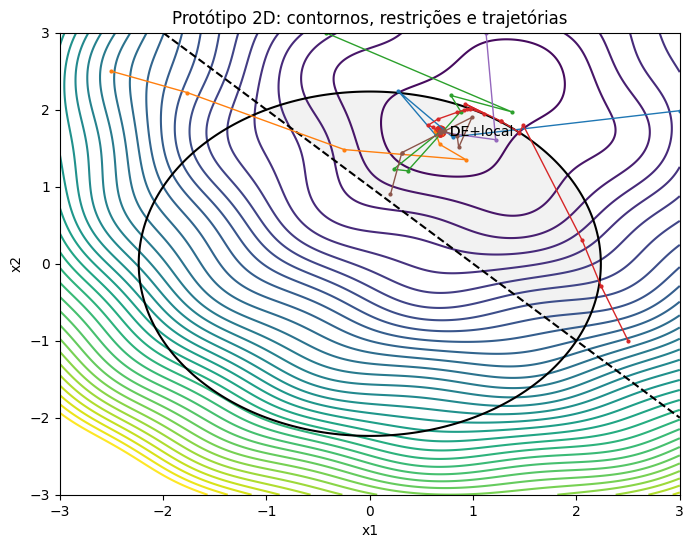

In [5]:
# Contorno + região viável + trajetórias
xs = np.linspace(-3, 3, 401)
ys = np.linspace(-3, 3, 401)
X, Y = np.meshgrid(xs, ys)
Z = (X - 1.0) ** 2 + (Y - 2.0) ** 2 + 0.5 * np.sin(3.0 * X) * np.sin(3.0 * Y)

# Máscara da região viável
feas = (X**2 + Y**2 <= 5.0) & (X + Y >= 1.0)

plt.figure(figsize=(8, 6))
levels = np.linspace(np.min(Z), np.percentile(Z, 98), 35)
plt.contour(X, Y, Z, levels=levels, cmap='viridis')

# contorno da fronteira do disco e da reta x+y=1
plt.contour(X, Y, X**2 + Y**2, levels=[5.0], colors='black', linewidths=1.5)
plt.contour(X, Y, X + Y, levels=[1.0], colors='black', linewidths=1.5, linestyles='--')

# sombrear região viável (leve)
plt.contourf(X, Y, feas.astype(float), levels=[0.5, 1.5], colors=['#000000'], alpha=0.05)

for r in local_results:
    if r.path is not None and len(r.path) > 1:
        plt.plot(r.path[:, 0], r.path[:, 1], '-o', ms=2, lw=1, label=f"{r.method} traj")

plt.scatter([g.x[0], ref.x[0]], [g.x[1], ref.x[1]], c=['tab:orange', 'tab:red'], s=60)
plt.text(g.x[0], g.x[1], '  DE', va='center')
plt.text(ref.x[0], ref.x[1], '  DE+local', va='center')

plt.title('Protótipo 2D: contornos, restrições e trajetórias')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

### Sensibilidade ao chute inicial (protótipo)

A seguir, comparamos valores finais e viabilidade para diferentes chutes iniciais e métodos locais.

In [6]:
rows = []
for r in local_results:
    rows.append((r.method, r.fun, is_feasible(r.x), r.success, r.x.copy()))

rows_sorted = sorted(rows, key=lambda t: t[1])
for m, fval, feas_ok, ok, x in rows_sorted:
    print(f"{m:12s}  f={fval: .6f}  feas={feas_ok}  ok={ok}  x={x}")

trust-constr  f=-0.221322  feas=True  ok=True  x=[0.68466855 1.71734025]
trust-constr  f=-0.221322  feas=True  ok=True  x=[0.68466795 1.71733831]
trust-constr  f=-0.221322  feas=True  ok=True  x=[0.68466795 1.71733831]
SLSQP         f=-0.221322  feas=True  ok=True  x=[0.68468126 1.71736326]
SLSQP         f=-0.221322  feas=True  ok=True  x=[0.68465965 1.71731089]
SLSQP         f=-0.221322  feas=True  ok=True  x=[0.68465496 1.71738901]


## Parte B — Estudo de caso: ajuste de curva logística (mínimos quadrados não linear)

Modelo:
$$
at y(t;L,k,t_0) = rac{L}{1+e^{-k(t-t_0)}}
$$
Objetivo (SSE):
$$
in_{L,k,t_0} um_i (y_i-at y(t_i;L,k,t_0))^2
$$

In [7]:
t, y, true_params = make_synthetic_data(seed=0, noise_std=2.0)
print('Verdadeiro:', true_params)

bounds_log = Bounds([0.0, 0.0, -5.0], [200.0, 2.0, 40.0])

# Vários chutes (sensibilidade)
inits = [np.array([60.0, 0.05, 5.0]), np.array([150.0, 1.2, 18.0]), np.array([90.0, 0.3, 10.0])]
local_fits = []
for x0 in inits:
    r = fit_local_lbfgsb(t, y, x0=x0, bounds=bounds_log)
    local_fits.append((x0, r))
    print(f"Local x0={x0} -> theta={r.theta}, SSE={r.fun:.3f}, ok={r.success}")

gfit, reffit = fit_global_de_then_local(t, y, bounds=bounds_log, seed=0)
print('=== Global → Local ===')
print(f"Global  : theta={gfit.theta}, SSE={gfit.fun:.3f}, ok={gfit.success}")
print(f"Refino  : theta={reffit.theta}, SSE={reffit.fun:.3f}, ok={reffit.success}")

Verdadeiro: (100.0, 0.35, 12.0)
Local x0=[6.e+01 5.e-02 5.e+00] -> theta=[100.37555798   0.35874671  12.01926105], SSE=178.164, ok=True
Local x0=[150.    1.2  18. ] -> theta=[100.37555401   0.35874676  12.01926052], SSE=178.164, ok=True
Local x0=[90.   0.3 10. ] -> theta=[100.37555558   0.35874673  12.01926056], SSE=178.164, ok=True
=== Global → Local ===
Global  : theta=[100.3754635    0.35874975  12.0192339 ], SSE=178.164, ok=True
Refino  : theta=[100.37546345   0.35874737  12.01923451], SSE=178.164, ok=True


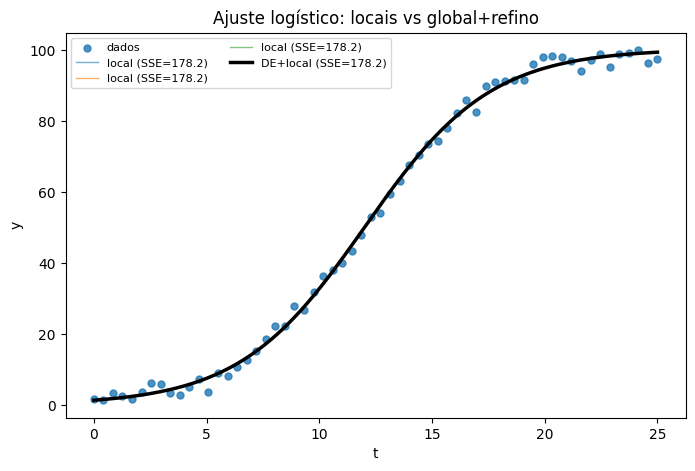

In [8]:
# Plot dos dados e do melhor ajuste encontrado
tt = np.linspace(t.min(), t.max(), 300)

plt.figure(figsize=(8, 5))
plt.scatter(t, y, s=25, alpha=0.8, label='dados')

# Curvas dos locais e do global-refinado
for x0, r in local_fits:
    plt.plot(tt, logistic(tt, *r.theta), lw=1.0, alpha=0.6, label=f'local (SSE={r.fun:.1f})')

plt.plot(tt, logistic(tt, *reffit.theta), lw=2.5, color='black', label=f'DE+local (SSE={reffit.fun:.1f})')

plt.title('Ajuste logístico: locais vs global+refino')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(ncols=2, fontsize=8)
plt.show()

### Sensibilidade (logística)

Comparamos os SSE finais para diferentes chutes iniciais e o resultado do DE + refino local.

In [9]:
vals = [(f'local x0={x0.tolist()}', r.fun, r.theta) for x0, r in local_fits]
vals.append(('DE+local', reffit.fun, reffit.theta))
vals_sorted = sorted(vals, key=lambda t: t[1])
for name, fun, th in vals_sorted:
    print(f"{name:28s} SSE={fun: .3f} theta={th}")

local x0=[150.0, 1.2, 18.0]  SSE= 178.164 theta=[100.37555401   0.35874676  12.01926052]
local x0=[90.0, 0.3, 10.0]   SSE= 178.164 theta=[100.37555558   0.35874673  12.01926056]
local x0=[60.0, 0.05, 5.0]   SSE= 178.164 theta=[100.37555798   0.35874671  12.01926105]
DE+local                     SSE= 178.164 theta=[100.37546345   0.35874737  12.01923451]
